In [ ]:
from google.colab import drive


In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
#from spellchecker import SpellChecker # pyspellchecker

import re, os, math, sklearn, datetime, pickle

In [5]:
# movies_df = pd.read_pickle('/content/gdrive/MyDrive/raw_data/title_plot_movieId.pkl')
movies_df = pd.read_pickle('../raw_data/title_plot_movieId.pkl')
movies_df

,title,plot_synopsis,movieId
0,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...",62
1,Scarface,"In May 1980, a Cuban man named Tony Montana (A...",4262
5,Flightplan,Kyle Pratt (Jodie Foster) is a propulsion engi...,37727
6,Little Caesar,Small-time Italian-American criminals Caesar E...,25773
7,Savages,The movie begins with a video being shot of me...,56956
...,...,...,...
7969,Thunderheart,"During the early 1970s, FBI agent Ray Levoi is...",7039
7970,One Night of Love,Opera singer Mary Barrett (Grace Moore) leaves...,124607
7971,One False Move,"Three criminals, Ray, Pluto and Fantasia (Ray'...",3728
7972,Lucky Numbers,"In 1988 Russ Richards (John Travolta), the wea...",3975


In [6]:
# ML_df = pd.read_csv('/content/gdrive/MyDrive/raw_data/MovieLens_20M/rating.csv')
ML_df = pd.read_csv('../raw_data/MovieLens_20M/rating.csv')
ML_df

FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/MovieLens_20M/rating.csv'

In [ ]:
prompt_embeddings = np.load('/content/gdrive/MyDrive/raw_data/processed_data_shared/embedding_summary.npy')

In [ ]:
movie_embeddings = np.load('/content/gdrive/MyDrive/raw_data/processed_data_shared/embeddings_plot.npy')

In [ ]:
movies_embed = pd.DataFrame(movie_embeddings, index= movies_df['movieId'])

In [ ]:
prompts_embed = pd.DataFrame(prompt_embeddings, index= movies_df['movieId'])

In [ ]:
user_df = ML_df[['userId', 'movieId', 'rating']]

# Preprocessing

In [ ]:
user_df_fil = user_df[user_df['movieId'].isin(list(movies_df['movieId']))]

In [ ]:
rating_counts = user_df_fil.groupby('movieId').count()

In [ ]:
rating_counts_fil = rating_counts[rating_counts['rating']>=500].sort_values(by='rating')

In [ ]:
rating_counts_fil

,userId,rating
movieId,,
63479,500,500
74450,500,500
51471,501,501
59037,501,501
8800,501,501
...,...,...
589,52244,52244
110,53769,53769
480,59715,59715


In [ ]:
movies_keep = list(rating_counts_fil.index)

In [ ]:
len(movies_keep)

2449

In [ ]:
user_df_fil = user_df[user_df['movieId'].isin(movies_keep)]

In [ ]:
user_df_fil.shape

(11915796, 3)

In [ ]:
input_df = pd.DataFrame(columns =['promptId', 'movieId', 'rating'])
for m_id in movies_keep:
    movie_search = user_df_fil[user_df_fil['movieId'] == m_id] # filter for one movie with 500 + recommendations
    movie_search_users = movie_search[movie_search['rating'] >= 4] # just keep users with good ratings for this particular movie
    users = movie_search_users['userId'] # get those users who did the good ratings
    movie_search_ratings = user_df_fil[user_df_fil['userId'].isin(users)].groupby('movieId', as_index=False).agg({'rating': 'mean'}) # get the average rating for all movies made by users who rated the particular movie HIGHLY
    prompt_ids = pd.DataFrame(np.full((len(movie_search_ratings['movieId']),),m_id),columns=['promptId']) #create a df with all the current movie/prompt id and the mean rating of all the other movies
    movie_search_input = pd.concat([prompt_ids,movie_search_ratings], axis=1) # concatenate
    input_df = pd.concat([input_df,movie_search_input]) # appends rows


In [ ]:
input_df.shape

(5953368, 3)

In [ ]:
2449*2449

5997601

In [ ]:
y = input_df['rating']/5

In [ ]:
id_df = input_df[['promptId', 'movieId']]

In [ ]:
X_0 = pd.merge(left=id_df, right = movies_embed, how='left', left_on='promptId', right_index=True)

In [ ]:
X = pd.merge(left=X_0, right = movies_embed, how='left', left_on='movieId', right_index=True)

In [ ]:
X.shape

(5953368, 258)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.30, shuffle=True, random_state=42)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
y_test.shape

(1786011,)

In [ ]:
eval_df = X_test[['movieId']]

# Baseline model

In [ ]:
user_df_sc = user_df_fil.copy()
user_df_sc['rating'] = user_df_sc['rating']/5

In [ ]:
means_df = user_df_sc.groupby('movieId').agg({'rating': 'mean'})

In [ ]:
y_means = pd.merge(left=eval_df, right=means_df, left_on='movieId', right_index=True, how='left')

In [ ]:
y_baseline = y_means['rating']

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, y_baseline)

0.004053428802720185

In [ ]:
(286-405)/405

-0.2938271604938272

# Model

In [ ]:
user_wants = keras.Input(shape= (128,))
movie_plot = keras.Input(shape= (128,))

## Liked genres Input:
user_liked = keras.layers.Dense(128, activation= 'relu')(user_wants)
liked_dropout_1 = keras.layers.Dropout(rate=0.2)(user_liked)
liked_hidden_1 = keras.layers.Dense(64, activation= 'relu')(liked_dropout_1)
liked_hidden_2 = keras.layers.Dense(32, activation= 'relu')(liked_hidden_1)
liked_hidden_3 = keras.layers.Dense(16, activation= 'relu')(liked_hidden_2)
liked_hidden_4 = keras.layers.Dense(8, activation= 'relu')(liked_hidden_3)

## Movie Input:
movie_input = keras.layers.Dense(128, activation= 'relu')(movie_plot)
movie_dropout_1 = keras.layers.Dropout(rate=0.2)(movie_input)
movie_hidden_1 = keras.layers.Dense(64, activation= 'relu')(movie_dropout_1)
movie_hidden_2 = keras.layers.Dense(32, activation= 'relu')(movie_hidden_1)
movie_hidden_3 = keras.layers.Dense(16, activation= 'relu')(movie_hidden_2)
movie_hidden_4 = keras.layers.Dense(8, activation= 'relu')(movie_hidden_3)

## Merging:
merged_model = keras.layers.concatenate([liked_hidden_4, movie_hidden_4])
merged_model_hidden_1 = keras.layers.Dense(32, activation= 'relu')(merged_model)
merged_dropout_1 = keras.layers.Dropout(rate=0.2)(merged_model_hidden_1)
merged_model_hidden_2 = keras.layers.Dense(16, activation= 'relu')(merged_dropout_1)
merged_model_hidden_3 = keras.layers.Dense(8, activation= 'relu')(merged_model_hidden_2)

## Output Layer:
output_rating = keras.layers.Dense(1, activation= 'linear')(merged_model_hidden_3)

## Molding the Model togther:
model = keras.Model(inputs= [user_wants, movie_plot], outputs= output_rating)

## Compiling the Model:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001), loss= 'mean_squared_error')

In [ ]:
batch_size = 128
epochs = 40
es = EarlyStopping(patience=4, restore_best_weights=True)

history = model.fit(x= [X_train.iloc[:, 2:130], X_train.iloc[:, 130:]],
                  y= y_train,
                  epochs= epochs, verbose= 1, batch_size= batch_size, validation_split= 0.1, shuffle= True, callbacks = [es])

Epoch 1/40
29302/29302 [==============================] - 152s 5ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 2/40
29302/29302 [==============================] - 152s 5ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 3/40
29302/29302 [==============================] - 151s 5ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 4/40
29302/29302 [==============================] - 152s 5ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 5/40
29302/29302 [==============================] - 151s 5ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 6/40
29302/29302 [==============================] - 151s 5ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 7/40
29302/29302 [==============================] - 152s 5ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 8/40
29302/29302 [==============================] - 151s 5ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/40
29302/29302 [==============================] - 152s 5ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/40
29302/29302 [=====================

# Evaluation

In [ ]:
model_3.evaluate([X_test.iloc[:, 2:130], X_test.iloc[:, 130:]], y_test)

55813/55813 [==============================] - 110s 2ms/step - loss: 0.0029


0.0028604266699403524

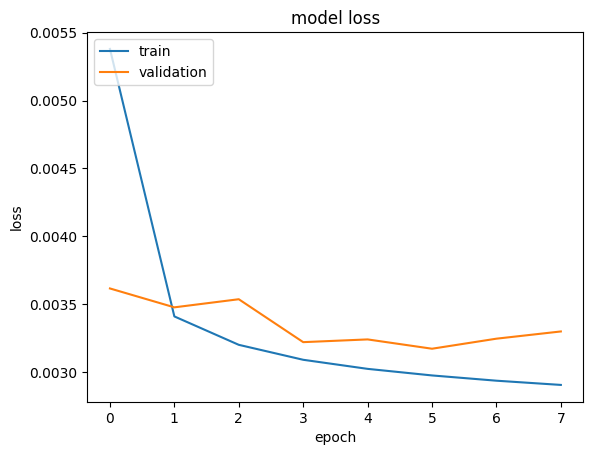

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
movies_embed.shape

(6204, 128)

In [ ]:
movies_embed_fil = movies_embed[movies_embed.index.isin(movies_keep)]

In [ ]:
movies_embed_fil.shape

(2449, 128)

In [ ]:
new_prompt = movies_embed_fil.head(1)

In [ ]:
new_prompts = pd.DataFrame(np.repeat(new_prompt.values, 2449, axis=0), columns=[str(i) + "_" for i in range(0,128,1)], index = movies_embed_fil.index)

In [ ]:
new_data = pd.concat([new_prompts,movies_embed_fil],axis=1, join='outer')

In [ ]:
new_data.shape

(2449, 256)

In [ ]:
y_pred = model_2.predict([new_data.iloc[:, 0:128], new_data.iloc[:, 128:]])

77/77 [==============================] - 0s 2ms/step


In [ ]:
ratings_pred = pd.DataFrame(y_pred, index = movies_embed_fil.index, columns=['ratings'])

In [ ]:
ratings_titles = pd.merge(left=ratings_pred, right = movies_df[['movieId','title']], on='movieId', how='left').sort_values(by='ratings', ascending=False)

In [ ]:
ratings_titles[0:20]

,movieId,ratings,title
48,1196,0.821670,Star Wars: Episode V - The Empire Strikes Back
532,908,0.818671,North by Northwest
82,5008,0.816089,Witness for the Prosecution
1575,4226,0.813389,Memento
249,1193,0.812274,One Flew Over the Cuckoo's Nest
49,750,0.812130,Dr. Strangelove or: How I Learned to Stop Worr...
81,3196,0.810436,Stalag 17
380,1203,0.809893,12 Angry Men
843,1204,0.809273,Lawrence of Arabia
1362,94466,0.809260,Black Mirror


In [ ]:
movies_embed_fil.head(1)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
movieId,,,,,,,,,,,,,,,,,,,,,
62,-0.530416,0.078947,-4.174719,-1.435039,-0.898514,-0.367455,0.821316,2.128489,-0.941272,0.09233,...,-0.210147,-1.126048,0.432286,-0.112529,-0.043328,0.398397,-2.933069,0.120806,-0.261634,1.418717


In [ ]:
pd.merge(left=new_prompt, right=movies_df, left_index=True, right_on='movieId', how='left')

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,title,plot_synopsis,movieId
0,-0.530416,0.078947,-4.174719,-1.435039,-0.898514,-0.367455,0.821316,2.128489,-0.941272,0.09233,...,-0.112529,-0.043328,0.398397,-2.933069,0.120806,-0.261634,1.418717,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...",62


In [ ]:
new_prompt_2 = movies_embed_fil.tail(1)

In [ ]:
movies_embed_fil.tail(1)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
movieId,,,,,,,,,,,,,,,,,,,,,
3728,-0.815098,-0.68295,-3.551226,-1.092486,0.052798,-1.020637,-0.344042,2.607695,-0.065807,0.684886,...,0.3909,-0.116829,-1.044274,-0.651202,-0.18648,1.035287,-1.555032,-0.338992,-1.114481,1.699152


In [ ]:
pd.merge(left=new_prompt_2, right=movies_df, left_index=True, right_on='movieId', how='left')

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,title,plot_synopsis,movieId
7971,-0.815098,-0.68295,-3.551226,-1.092486,0.052798,-1.020637,-0.344042,2.607695,-0.065807,0.684886,...,-0.651202,-0.18648,1.035287,-1.555032,-0.338992,-1.114481,1.699152,One False Move,"Three criminals, Ray, Pluto and Fantasia (Ray'...",3728


In [ ]:
new_prompts_2 = pd.DataFrame(np.repeat(new_prompt_2.values, 2449, axis=0), columns=[str(i) + "_" for i in range(0,128,1)], index = movies_embed_fil.index)
new_data_2 = pd.concat([new_prompts_2,movies_embed_fil],axis=1, join='outer')
y_pred_2 = model_2.predict([new_data_2.iloc[:, 0:128], new_data_2.iloc[:, 128:]])

77/77 [==============================] - 0s 2ms/step


In [ ]:
y_pred_2

array([[0.72760844],
       [0.7731784 ],
       [0.7136944 ],
       ...,
       [0.6602894 ],
       [0.5566347 ],
       [0.6806607 ]], dtype=float32)

In [ ]:
ratings_pred_2 = pd.DataFrame(y_pred_2, index = movies_embed_fil.index, columns=['ratings'])
ratings_titles_2 = pd.merge(left=ratings_pred_2, right = movies_df[['movieId','title']], on='movieId', how='left').sort_values(by='ratings', ascending=False)


In [ ]:
ratings_titles_2[0:20]

,movieId,ratings,title
53,926,0.832605,All About Eve
1574,923,0.831149,Citizen Kane
314,1252,0.830635,Chinatown
49,750,0.830087,Dr. Strangelove or: How I Learned to Stop Worr...
1096,1178,0.824577,Paths of Glory
380,1203,0.822995,12 Angry Men
730,1213,0.820868,Goodfellas
82,5008,0.819879,Witness for the Prosecution
1121,1945,0.819574,On the Waterfront
532,908,0.819337,North by Northwest


In [ ]:
new_prompt_3 = movies_embed_fil.head(2)

In [ ]:
new_prompts_3 = pd.DataFrame(np.repeat([new_prompt_3.values[1]], 2449, axis=0), columns=[str(i) + "_" for i in range(0,128,1)], index = movies_embed_fil.index)
new_data_3 = pd.concat([new_prompts_3,movies_embed_fil],axis=1, join='outer')
y_pred_3 = model_2.predict([new_data_3.iloc[:, 0:128], new_data_3.iloc[:, 128:]])

77/77 [==============================] - 0s 2ms/step


In [ ]:
ratings_pred_3 = pd.DataFrame(y_pred_3, index = movies_embed_fil.index, columns=['ratings'])
ratings_titles_3 = pd.merge(left=ratings_pred_3, right = movies_df[['movieId','title']], on='movieId', how='left').sort_values(by='ratings', ascending=False)


In [ ]:
ratings_titles_3[0:20]

,movieId,ratings,title
49,750,0.830228,Dr. Strangelove or: How I Learned to Stop Worr...
1574,923,0.827645,Citizen Kane
314,1252,0.827458,Chinatown
53,926,0.826420,All About Eve
380,1203,0.822614,12 Angry Men
532,908,0.821920,North by Northwest
1096,1178,0.821073,Paths of Glory
48,1196,0.820670,Star Wars: Episode V - The Empire Strikes Back
82,5008,0.820512,Witness for the Prosecution
730,1213,0.818941,Goodfellas


In [ ]:
import pickle

In [ ]:
pickle.dump(model_2, open('/content/gdrive/MyDrive/model_2.pkl', 'wb'))

In [ ]:
pickle.dump(model, open('model_1.pkl', 'wb'))

In [ ]:
with open('/content/gdrive/MyDrive/model_3.pkl', 'wb') as files:
    pickle.dump(model_3, files)